##### Copyright 2019 Qiyang Hu

In [0]:
#@title Licensed under MIT License (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://huqy.github.io/idre_learning_machine_learning/LICENSE.md
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [0]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import numpy as np; 
import pandas as pd;
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
from graphviz import Source

from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn import ensemble, tree, svm, naive_bayes, neighbors, linear_model, gaussian_process, neural_network
from sklearn.metrics import accuracy_score, f1_score, auc, roc_curve, roc_auc_score, make_scorer
from sklearn.model_selection import cross_val_score

np.random.seed(0)

%matplotlib inline

def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)


# Regression: Linear and Polynomial 

In [0]:
mean, cov = [5, 5], [(0.4, 0.5), (0.5, 1)]
x, y = np.random.multivariate_normal(mean, cov, 20).T
x, y = pd.Series(x, name="x_var"), pd.Series(y, name="y_var")

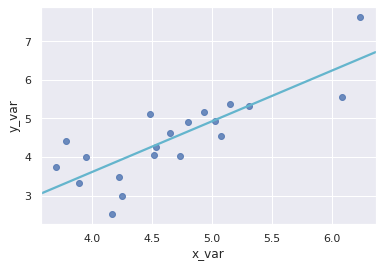

In [0]:
ax = sns.regplot(x=x, y=y, ci=None, line_kws={'color':'c'})

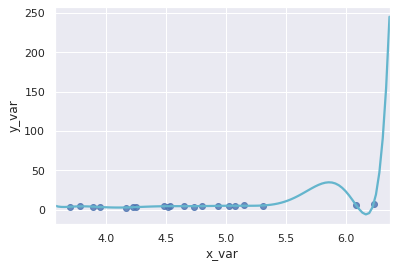

In [0]:
ax = sns.regplot(x=x, y=y, ci=None, order=11, line_kws={'color':'c'})

In [0]:
x = x.values.reshape(-1,1)
y = y.values.reshape(-1,1)

In [0]:
clf = LinearRegression()
clf.fit(x,y)
pred = clf.predict(x)
score = clf.score(y, pred)

print("Coefficient of determination R^2 of the prediction:", score)
print("Coefficients for the linear regression problem:", clf.coef_[0])
print("Bias term for the linear regression problem:", clf.intercept_)

Coefficient of determination R^2 of the prediction: -0.046539229482777555
Coefficients for the linear regression problem: [1.31676205]
Bias term for the linear regression problem: [-1.66085188]


### Generating Data Points

In [0]:
def f(x):
    """ function to approximate by linear and polynomial interpolation"""
    return 0.05*x*x + 0.9 * x +1

# generate points used to plot
x_plot = np.linspace(5, 95, 1000)

n_train = 20
n_test = 10
err_range = 100

np.random.seed(0)

x_whole = np.linspace(5, 95, 1000)
rng = np.random.RandomState(0)
rng.shuffle(x_whole)

# generate training points
x_train = np.sort(x_whole[:n_train])
delta   = np.random.uniform(-err_range, err_range, n_train)
y_train = f(x_train) + delta

# generate testing points
x_test = np.sort(x_whole[n_train:n_train+n_test])
delta  = np.random.uniform(-err_range, err_range, n_test)
y_test = f(x_test) + delta


# create matrix versions of these arrays
X_train = x_train[:, np.newaxis]
X_test  = x_test[:, np.newaxis]
X_plot  = x_plot[:, np.newaxis]

### Regression fit

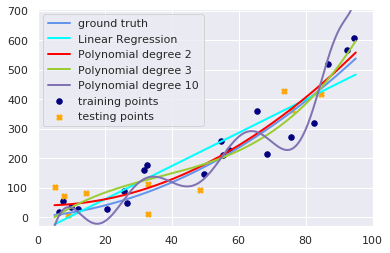

In [0]:
colors = ['red', 'yellowgreen', 'm']
lw = 2
plt.plot(x_plot, f(x_plot), color='cornflowerblue', linewidth=lw, label="ground truth")
plt.scatter(x_train, y_train, color='navy', s=30, marker='o', label="training points")
plt.scatter(x_test, y_test, color='orange', s=30, marker='X', label="testing points")

model = LinearRegression().fit(X_train,y_train)
y_plot = model.predict(X_plot)
plt.plot(x_plot, y_plot, color='cyan', linewidth=lw, label="Linear Regression")

for count, degree in enumerate([2, 3, 10]):
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=0))
    model.fit(X_train, y_train)
    y_plot = model.predict(X_plot)
    #if degree != 2: break
    plt.plot(x_plot, y_plot, color=colors[count], linewidth=lw, label="Polynomial degree %d" % degree)

plt.legend(loc='upper left')
plt.axis([0, 100, np.min(y_train)-50, np.max(y_train)+100])
plt.show()

### Check the loss function

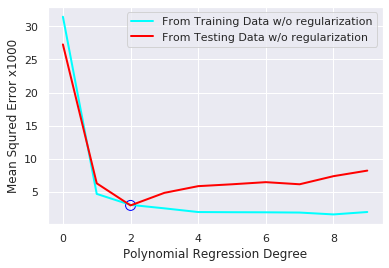

In [0]:
col = []
loss = pd.DataFrame(columns = col)
idx = 0

withreg = False

for degree in np.arange(10):
  loss.loc[idx, 'degree'] = degree
  for a in np.arange( 2 if withreg else 1 ) :
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=a))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_pred)
    y_pred = model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred)
    loss.loc[idx, "mse train %d" % a] = mse_train
    loss.loc[idx, "mse test %d" % a] = mse_test
  
  idx+=1
  
plt.plot(loss['degree'], loss['mse train 0']/1000, color='cyan', linewidth=lw, label="From Training Data w/o regularization")
plt.plot(loss['degree'], loss['mse test 0']/1000, color='red', linewidth=lw, label="From Testing Data w/o regularization")

if withreg:
  plt.plot(loss['degree'], loss['mse train 1']/1000, color='m', linestyle='--', linewidth=lw, label="From Training Data w regularization")
  plt.plot(loss['degree'], loss['mse test 1']/1000, color='green', linestyle='--', linewidth=lw, label="From Testing Data w regularization")
  
plt.scatter(2, np.min(loss['mse test 0'])/1000, s=100, facecolors='none', edgecolors='blue')

plt.legend(loc='upper right')
plt.xlabel('Polynomial Regression Degree')
plt.ylabel('Mean Squred Error x1000')
plt.show()

### Bias and Variance

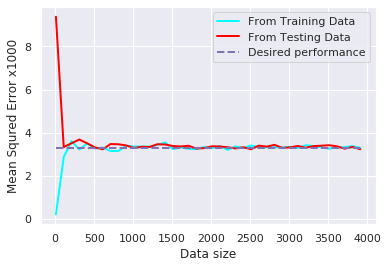

In [0]:
def f(x):
    """ function to approximate by linear and polynomial interpolation"""
    return 0.05*x*x + 0.9 * x +1

np.random.seed(0)
n_grid = 8000
lw = 2

x_whole = np.linspace(5, 95, n_grid)

# generate points used to plot
x_plot = np.linspace(5, 95, n_grid)

col = []
loss = pd.DataFrame(columns = col)
idx = 0

for n in np.arange(10, 4000, 100):
  n_train = n
  n_test = n
  err_range = 100

  # generate training points
  rng = np.random.RandomState(0)
  rng.shuffle(x_whole)

  x_train = np.sort(x_whole[:n_train])
  delta   = np.random.uniform(-err_range, err_range, n_train)
  y_train = f(x_train) + delta

  # generate testing points
  x_test = np.sort(x_whole[n_train:n_train+n_test])
  delta  = np.random.uniform(-err_range, err_range, n_test)
  y_test = f(x_test) + delta

  # create matrix versions of these arrays
  X_train = x_train[:, np.newaxis]
  X_test  = x_test[:, np.newaxis]
  X_plot  = x_plot[:, np.newaxis]
  
  # change the degree to have different complexity of the model
  degree = 4
  loss.loc[idx, 'problem size'] = n
  model = make_pipeline(PolynomialFeatures(degree), Ridge())
  model.fit(X_train, y_train)
  y_pred = model.predict(X_train)
  mse_train = mean_squared_error(y_train, y_pred)
  y_pred = model.predict(X_test)
  mse_test = mean_squared_error(y_test, y_pred)
  loss.loc[idx, "mse train"] = mse_train
  loss.loc[idx, "mse test"] = mse_test
  loss.loc[idx, "variance"] = abs(mse_train-mse_test)
  loss.loc[idx, "desired perf"] = 3.3
    
  idx+=1
  
plt.plot(loss['problem size'], loss['mse train']/1000, color='cyan', linewidth=lw, label="From Training Data")
plt.plot(loss['problem size'], loss['mse test']/1000, color='red', linewidth=lw, label="From Testing Data")

plt.plot(loss['problem size'], loss['desired perf'], color='m', linewidth=lw, linestyle='--', label="Desired performance")

plt.legend(loc='upper right')
plt.xlabel('Data size')
plt.ylabel('Mean Squred Error x1000')
plt.show()

### Regularization

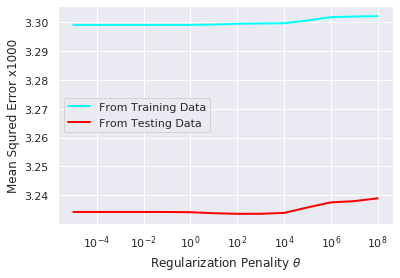

In [0]:
col = []
loss = pd.DataFrame(columns = col)
idx = 0

withreg = False

degree = 8
for a in np.power(10, range(14)) / 100000:
  loss.loc[idx, 'a'] = a
  model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=a))
  model.fit(X_train, y_train)
  y_pred = model.predict(X_train)
  mse_train = mean_squared_error(y_train, y_pred)
  y_pred = model.predict(X_test)
  mse_test = mean_squared_error(y_test, y_pred)
  loss.loc[idx, "mse train"] = mse_train
  loss.loc[idx, "mse test"] = mse_test
  
  idx+=1
  
plt.plot(loss['a'], loss['mse train']/1000, color='cyan', linewidth=lw, label="From Training Data")
plt.plot(loss['a'], loss['mse test']/1000, color='red', linewidth=lw, label="From Testing Data")

  
#plt.scatter(2, np.min(loss['mse test 0'])/1000, s=100, facecolors='none', edgecolors='blue')

plt.legend(loc='center left')
plt.xlabel(r'Regularization Penality $\theta$')
plt.ylabel('Mean Squred Error x1000')
plt.xscale('log')
plt.show()

# Classification: Logistic Regression, Naive Bayes, Decision Tree, ...

In [0]:
n = 40
mean, cov = [4, 6], [(0.4, 0.5), (0.5, 1)]
np.random.seed(0)
x1, x2 = np.random.multivariate_normal(mean, cov, n).T
y1 = np.zeros(n)
y2 = np.ones(n)
x = np.concatenate((x1, x2), axis=None)
y = np.concatenate((np.zeros(n), np.ones(n)), axis=None)
x, y = pd.Series(x, name="x_var"), pd.Series(y, name="Probability")

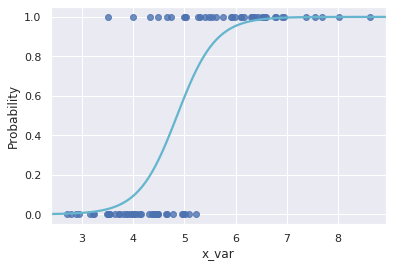

In [0]:
ax = sns.regplot(x=x, y=y, ci=None, logistic=True, line_kws={'color':'c'})

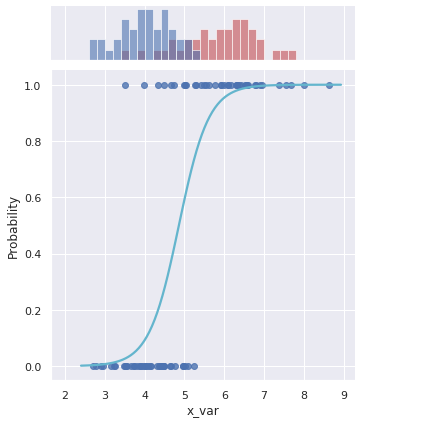

In [0]:
g = sns.JointGrid(x=x, y=y)
g = g.plot_joint(sns.regplot, ci=None, logistic=True, line_kws={'color':'c'})
g.ax_marg_x.hist(x2, color="r", alpha=.6, bins=np.arange(2, 8, 0.2))
g.ax_marg_x.hist(x1, color="b", alpha=.6, bins=np.arange(2, 8, 0.2))
g.ax_marg_y.set_axis_off()

In [0]:
x = x.values.reshape(-1,1)

In [0]:
clf = LogisticRegression()

In [0]:
clf = naive_bayes.GaussianNB()

In [0]:
clf.fit(x,y)

pred = clf.predict(x)

acc = accuracy_score(y, pred)
f1 = f1_score(y, pred)
cv = cross_val_score(clf, x, y).mean()

print("Accuracy Score:", acc)
print("F1 score or balanced F-score:", f1)
print("Cross Validation Score:", cv)

Accuracy Score: 0.8625
F1 score or balanced F-score: 0.8607594936708861
Cross Validation Score: 0.8397435897435898


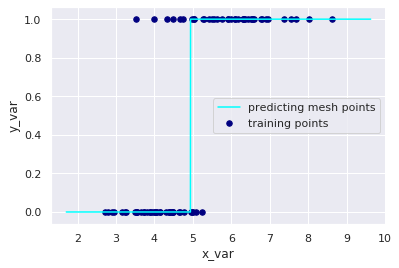

In [0]:
x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
xx = np.linspace(x_min, x_max, 10000)
yy = clf.predict(xx.reshape(-1,1))
plt.scatter(x, y, color='navy', s=30, marker='o', label="training points")
#plt.scatter(xx, yy, color='red', s=30, marker='o', label="training points")
plt.plot(xx, yy, color='cyan', label="predicting mesh points")
plt.legend(loc='center right')
plt.xlabel('x_var')
plt.ylabel('y_var')
plt.show()

In [0]:
clf = DecisionTreeClassifier(max_depth=1)
clf.fit(x,y)
pred = clf.predict(x)
acc = accuracy_score(y, pred)
f1 = f1_score(y, pred)
cv = cross_val_score(clf, x, y).mean()

print("Accuracy Score:", acc)
print("F1 score or balanced F-score:", f1)
print("Cross Validation Score:", cv)

Accuracy Score: 0.8875
F1 score or balanced F-score: 0.8732394366197184
Cross Validation Score: 0.8525641025641026


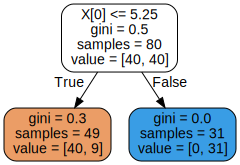

In [0]:
Source( tree.export_graphviz(clf, out_file=None, rounded=True, filled=True) )

In [0]:
clf = RandomForestClassifier(max_depth=1)
clf.fit(x,y)
pred = clf.predict(x)
acc = accuracy_score(y, pred)
f1 = f1_score(y, pred)
cv = cross_val_score(clf, x, y).mean()

print("Accuracy Score:", acc)
print("F1 score or balanced F-score:", f1)
print("Cross Validation Score:", cv)

Accuracy Score: 0.8875
F1 score or balanced F-score: 0.88
Cross Validation Score: 0.8525641025641026


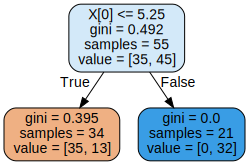

In [0]:
# default 10 estimators in RandomForestClassifier
estimator = clf.estimators_[2]
Source( tree.export_graphviz(estimator, out_file=None, rounded=True, filled=True) )